In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example

from behavenet.plotting.cond_ae_utils import get_crop
from behavenet.plotting.cond_ae_utils import get_input_range
from behavenet.plotting.cond_ae_utils import get_labels_2d_for_trial
from behavenet.plotting.cond_ae_utils import get_model_input
from behavenet.plotting.cond_ae_utils import interpolate_2d
from behavenet.plotting.cond_ae_utils import plot_2d_frame_array

save_outputs = False  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

### setup - define model

In [3]:
import torch
from behavenet.fitting.utils import get_best_model_and_data
from behavenet.fitting.eval import get_reconstruction
from behavenet.data.utils import get_data_generator_inputs

# movie info
save_outputs = False
max_frames = 100

# dataset info
dataset = 'dipoppa'  # ibl | musall | dipoppa
n_ae_latents = 6  # not including label-related latents
model_class = 'cond-ae-msp'  # 'cond-ae' | 'cond-ae-msp'
frac = 1.0

# set model info
version = 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
#     'experiment_name': 'ae-example-500-new-arch-2',
    'experiment_name': 'latent_search',
    'model_class': model_class,
    'model_type': 'conv',
    'rng_seed_data': 0,
    'trial_splits': '8;1;1;0',
    'train_frac': float(frac),
    'rng_seed_model': 0,
    'conditional_encoder': False,
}


lab = 'dipoppa'
expt = 'MSP_pupil'
session = '6'
n_labels = 3
label_min_p = 5
label_max_p = 95
show_markers = True
figsize = (15, 7.5)
ch = 0

if model_class == 'cond-ae-msp':
    n_ae_latents += n_labels
hparams['n_ae_latents'] = n_ae_latents

# programmatically fill out other hparams options
get_lab_example(hparams, lab, expt)
hparams['session'] = session
hparams['session_dir'], sess_ids = get_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)

# build model(s)
from behavenet.models import AEMSP as Model
version = 5#get_best_model_version(hparams['expt_dir'])[0]
model_ae, data_generator = get_best_model_and_data(hparams, Model, version=version)

latent_range = get_input_range(
    'latents', hparams, model=model_ae, data_gen=data_generator)
if True: #hparams['session'] == '192_coarse-13_dgp':  # plot labels/compute ranges using good ones
    label_range = get_input_range(
        'labels', hparams, sess_ids=sess_ids, sess_idx=sess_idx, 
        min_p=label_min_p, max_p=label_max_p)
    label_sc_range = get_input_range(
        'labels_sc', hparams, sess_ids=sess_ids, sess_idx=sess_idx,
        min_p=label_min_p, max_p=label_max_p)

Loading model defined in /home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/SB028/6/cond-ae-msp/conv/09_latents/latent_search/version_5/meta_tags.pkl
using data from following sessions:
/home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/SB028/6
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
dipoppa_MSP_pupil_SB028_6
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/6/data.hdf5')])

using data from following sessions:
/home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/SB028/6
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
dipoppa_MSP_pupil_SB028_6
    signals: ['labels_sc']
    transforms: OrderedDict([('labels_sc', None)])
    paths: OrderedDict([('labels_sc', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/6/data.hdf5')])



### load data

In [4]:
plot_trial = False
if plot_trial:
    trial = None
    trial_idx = 11
    ims_pt, ims_np, latents_np, labels_pt, labels_np, labels_2d_pt, labels_2d_np = get_model_input(
        data_generator, hparams, model_ae, trial_idx=trial_idx, trial=trial,
        compute_latents=True)
    if dataset == 'dipoppa':
        plt.figure(figsize=(15, 5))
        plt.plot(labels_np + np.arange(n_labels))
    else:
        fig, axes = plt.subplots(10, 10, figsize=(15, 15))
        for i in range(10):
            for j in range(10):
                c = i * 10 + j
                axes[i, j].imshow(ims_np[c, ch], vmin=0, vmax=1, cmap='gray')
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

# Explore 2D label space

In [8]:
n_frames = 3
crop_type = None  # 'fixed' | None

if dataset == 'ibl':
    trial_idx = 11  # 11/99 a good one
    batch_idx = 99
    label_idxs = [5, 1]  # y label then x (left paw)
    csl = False
    crop_kwargs_ = {'y_0': 106, 'y_ext': 24, 'x_0': 106, 'x_ext': 24}
elif dataset == 'musall':
    trial_idx = 11
    batch_idx = 58  # 47: levers up || 99: levers down  || 58: levers mid
#     label_idxs = [4, 5]  # spout ys
    label_idxs = [2, 3]  # levers
    csl = True
elif dataset == 'dipoppa':
    trial_idx = 11
    batch_idx = 39  # 60: large pupil || 99: small pupil
    label_idxs = [1, 2]  # pupil loc
    #label_idxs = [2, 0]  # pupil area
    csl = True

ims_pt, ims_np, latents_np, labels_pt, labels_np, labels_2d_pt, labels_2d_np = \
    get_model_input(data_generator, hparams, model_ae, trial_idx=trial_idx, 
    compute_latents=True, compute_scaled_labels=csl, compute_2d_labels=not csl)

if crop_type == 'fixed':
    crop_kwargs = crop_kwargs_
else:
    crop_kwargs = None

ims_label, markers_loc_label, ims_crop_label = interpolate_2d(
    'labels', model_ae, ims_pt[None, batch_idx, :], latents_np[None, batch_idx, :], 
    labels_np[None, batch_idx, :], labels_2d_np[None, batch_idx, :], 
    mins=[label_range['min'][label_idxs[0]], label_range['min'][label_idxs[1]]], 
    maxes=[label_range['max'][label_idxs[0]], label_range['max'][label_idxs[1]]], 
    n_frames=n_frames, input_idxs=label_idxs, crop_type=crop_type, 
    mins_sc=[label_sc_range['min'][label_idxs[0]], label_sc_range['min'][label_idxs[1]]], 
    maxes_sc=[label_sc_range['max'][label_idxs[0]], label_sc_range['max'][label_idxs[1]]], 
    crop_kwargs=crop_kwargs, ch=ch)

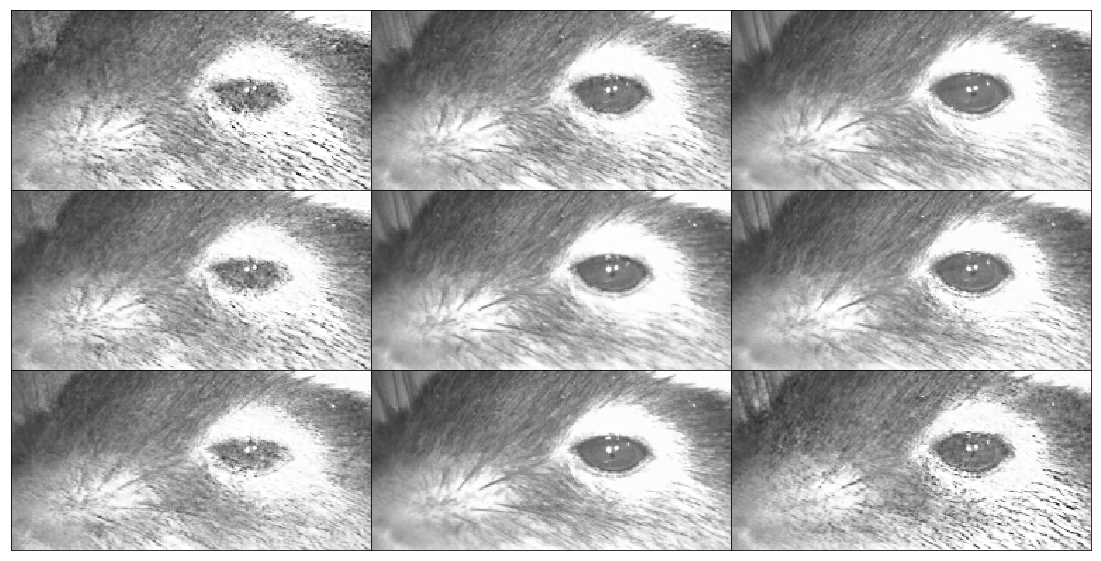

In [9]:
show_markers = False
marker_kwargs = {
    'markersize': 20, 'markeredgewidth': 3, 'markeredgecolor': [1, 1, 0],
    'fillstyle': 'none'}

if save_outputs:
    save_file = os.path.join(
        get_user_dir('fig'), 
        'ae', 'D=%02i_label-manipulation_%s_%s-crop.png' % 
        (hparams['n_ae_latents'], hparams['session'], crop_type))
else:
    save_file = None

if crop_type:
    plot_2d_frame_array(
        ims_crop_label, markers=None, marker_kwargs=marker_kwargs, save_file=None,
        figsize=figsize)
else:
    if show_markers:
        markers_ = markers_loc_label
    else:
        markers_ = None
    plot_2d_frame_array(
        ims_label, markers=markers_, marker_kwargs=marker_kwargs, save_file=None,
        figsize=figsize)

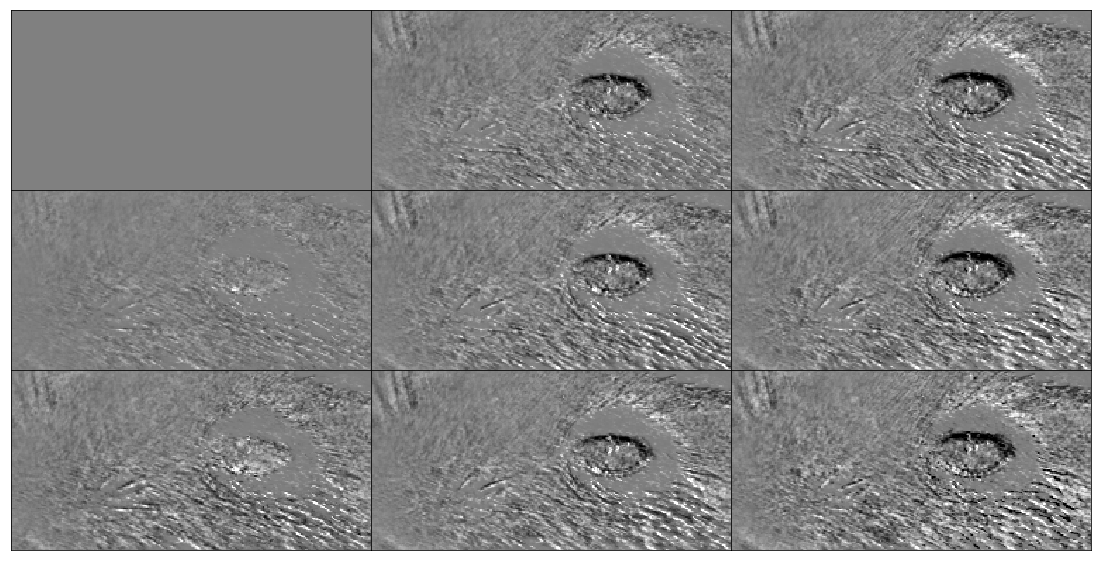

In [10]:
base_im = ims_label[0][0]
ims_label_diff = [[None for _ in range(n_frames)] for _ in range(n_frames)]
for r, ims_list_y in enumerate(ims_label):
    for c, im in enumerate(ims_list_y):
        ims_label_diff[r][c] = 0.5 + (im - base_im)
        # ims_latent_diff[r][c] = np.square(im - base_im)
plot_2d_frame_array(
    ims_label_diff, markers=markers_, marker_kwargs=marker_kwargs, save_file=None, 
    figsize=figsize)

# Explore 2D latent space

In [12]:
n_frames = 3
crop_type = None #'label' # 'label' | None
latent_idxs = np.array([5, 4])
ch = 0

if dataset == 'ibl':
    crop_kwargs_fixed = {'y_0': 126, 'y_ext': 48, 'x_0': 128, 'x_ext': 48}
    crop_label_idx = 1  # left paw
    crop_label_y_ext = 48
    crop_label_x_ext = 48
    marker_idxs = [5, 1]
elif dataset == 'musall':
    trial_idx = 11
    batch_idx = 99  # 47: levers up || 99: levers down
    marker_idxs = [0, 1]
elif dataset == 'dipoppa':
    trial_idx = 11
    batch_idx = 60  # 60: large pupil || 99: small pupil
    marker_idxs = [0, 1]
else:
    raise Exception
    
    
ims_pt, ims_np, latents_np, labels_pt, labels_np, labels_2d_pt, labels_2d_np = \
    get_model_input(data_generator, hparams, model_ae, trial=None, trial_idx=trial_idx,
    compute_latents=True, compute_scaled_labels=csl, compute_2d_labels=not csl)

if crop_type == 'fixed':
    crop_kwargs = crop_kwargs_fixed
elif crop_type == 'label':
    if not hparams['conditional_encoder']:
        labels_2d_pt, labels_2d_np = get_labels_2d_for_trial(hparams2, sess_ids, batch_idx)
    tmp = np.copy(labels_2d_np)[None, batch_idx]
    t, y, x = np.where(tmp[0]==1)
    y_0 = int(y[crop_label_idx])
    x_0 = int(x[crop_label_idx])
    crop_kwargs = {
        'y_0': y_0, 'y_ext': crop_label_y_ext, 'x_0': x_0, 'x_ext': crop_label_x_ext}
else:
    crop_kwargs = None
    
if hparams['model_class'] == 'cond-ae-msp':
    latent_idxs += n_labels

ims_latent, markers_loc_latent_, ims_crop_latent = interpolate_2d(
    'latents', model_ae, ims_pt[None, batch_idx, :], latents_np[None, batch_idx, :], 
    labels_np[None, batch_idx, :], labels_2d_np[None, batch_idx, :], 
    mins=[latent_range['min'][latent_idxs[0]], latent_range['min'][latent_idxs[1]]], 
    maxes=[latent_range['max'][latent_idxs[0]], latent_range['max'][latent_idxs[1]]], 
    n_frames=n_frames, input_idxs=latent_idxs, crop_type=crop_type, 
    mins_sc=None, maxes_sc=None, crop_kwargs=crop_kwargs, marker_idxs=marker_idxs, ch=ch)

if crop_type:
    markers_loc_crop = copy.deepcopy(markers_loc_latent_)
else:
    markers_loc = copy.deepcopy(markers_loc_latent_)

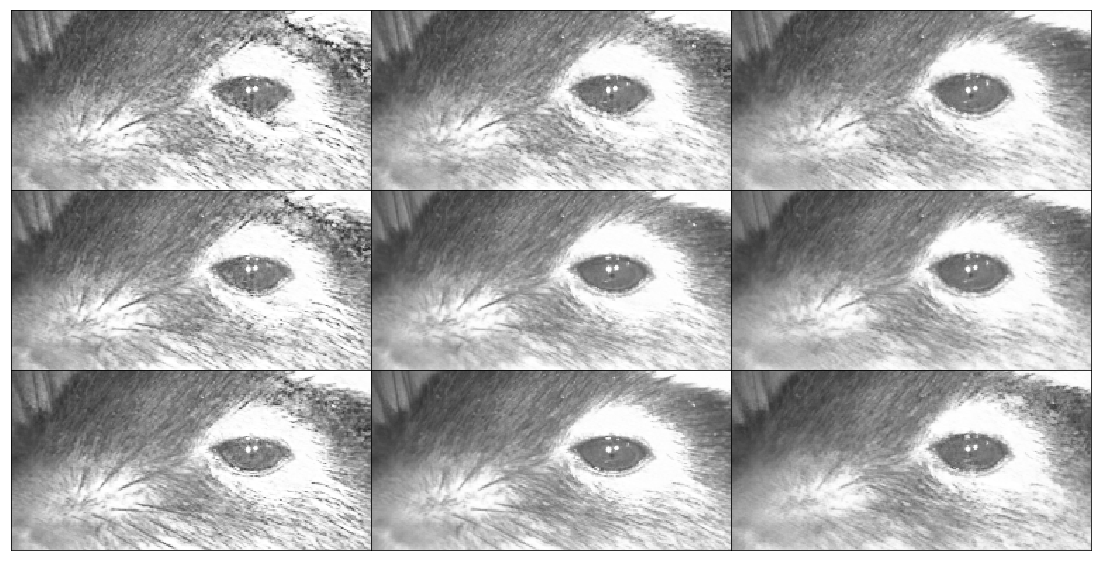

In [13]:
# show_markers = False
if save_outputs:
    save_file = os.path.join(
        get_user_dir('fig'), 
        'ae', 'D=%02i_latent-manipulation_%s_%s-crop.png' % 
        (hparams['n_ae_latents'], hparams['session'], crop_type))
else:
    save_file = None

if crop_type:
    markers_ = markers_loc_crop if show_markers else None
    marker_kwargs = {
        'markersize': 30, 'markeredgewidth': 8, 'markeredgecolor': [1, 1, 0],
        'fillstyle': 'none'}
    plot_2d_frame_array(
        ims_crop_latent, markers=markers_, marker_kwargs=marker_kwargs, save_file=None,
        figsize=figsize)
else:
    markers_ = markers_loc if show_markers else None
    marker_kwargs = {
        'markersize': 20, 'markeredgewidth': 5, 'markeredgecolor': [1, 1, 0],
        'fillstyle': 'none'}
    plot_2d_frame_array(
        ims_latent, markers=markers_, marker_kwargs=marker_kwargs, save_file=None,
        figsize=figsize)

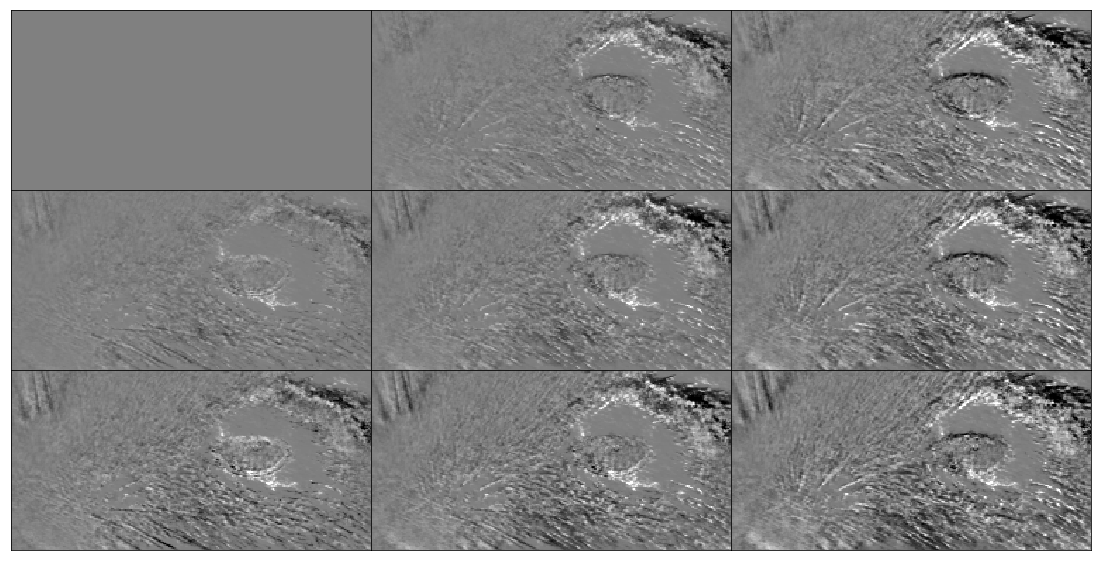

In [14]:
base_im = ims_latent[0][0]
ims_latent_diff = [[None for _ in range(n_frames)] for _ in range(n_frames)]
for r, ims_list_y in enumerate(ims_latent):
    for c, im in enumerate(ims_list_y):
        ims_latent_diff[r][c] = 0.5 + (im - base_im)
        # ims_latent_diff[r][c] = np.square(im - base_im)
plot_2d_frame_array(
    ims_latent_diff, markers=markers_, marker_kwargs=marker_kwargs, save_file=None,
    figsize=figsize)